The available market price data spans over years 2019 to 2023. Please enter the data year(s) of interest, separated by a space.
2019 2020 2021 2022 2023


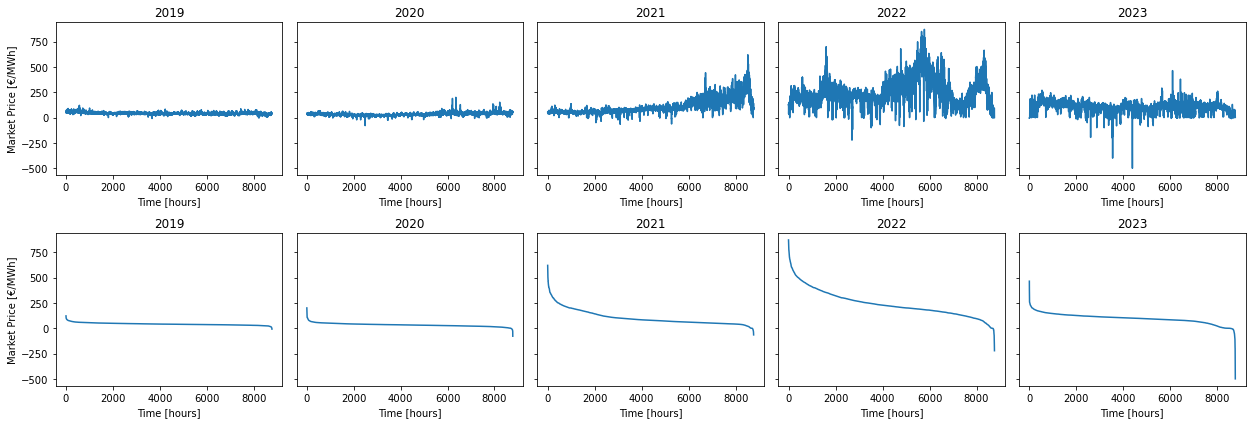

In [1]:
#1. Energy Market Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print('The available market price data spans over years 2019 to 2023. Please enter the data year(s) of interest, separated by a space.')
File_names=['Day-ahead Prices_201901010000-202001010000.csv',
            'Day-ahead Prices_202001010000-202101010000.csv',
            'Day-ahead Prices_202101010000-202201010000.csv',
            'Day-ahead Prices_202201010000-202301010000.csv',
            'Day-ahead Prices_202301010000-202401010000.csv']
while True:
    arr = input()   
    l = list(map(int,arr.split(' ')))
    if all(2019 <= x <= 2023 for x in l):
        break

MP_raw=[]
for x in l:
    data=[]
    df = pd.read_csv(File_names[x-2019])
    data = df.iloc[:, 1].values
    nan_indices = np.where(np.isnan(data))[0]
    for i in nan_indices:
        data[i]=0.5*(data[i-1]+data[i+1])
    MP_raw.append(data)
    
fig, axes = plt.subplots(nrows=2, ncols=len(MP_raw), figsize=(3.5*len(MP_raw), 6),sharey=True)

for i in range(len(MP_raw)):
    ax = axes[0,i]
    ax.plot(MP_raw[i])
    if i ==0:
        ax.set_ylabel('Market Price [€/MWh]')
    ax.set_xlabel('Time [hours]')
    ax.set_title(str(l[i]))
    
    ax = axes[1,i]
    ax.plot(np.sort(np.array(MP_raw[i]))[::-1])
    ax.set_xlabel('Time [hours]')
    if i ==0:
        ax.set_ylabel('Market Price [€/MWh]')
    ax.set_title(str(l[i]))
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from scipy.optimize import fsolve
# Coefficients
a1 = 1.5184
a2 = 1.5421E-03
a3 = 9.523E-05
a4 = 9.84E-08
r1 = 4.45153E-05
r2 = 6.88874E-09
d1 = -3.12996E-06
d2 = 4.47137E-07
s = 0.33824
t1 = -0.01539
t2 = 2.00181
t3 = 15.24178
B1 = 4.50E-05
B2 = 1.02116
B3 = -247.26
B4 = 2.06972
B5 = -0.03571
f11 = 478645.74
f12 = -2953.15
f21 = 1.0396
f22 = -0.00104
F_const = 96485.3321
M_H2 = 2.0159 # molar mass of H2 in kg/mol
HHV = 39.41
i_max=5000
A_cell = 0.2 # cell area in m2
#************************************************************************
#Functions
# Reversible cell voltage
def U_rev(Temp):
    Temp_K = Temp + 273.15
    U_rev = a1 - a2 * Temp_K + a3 * Temp_K * np.log(Temp_K) + a4 * Temp_K**2
    return U_rev
# Real cell voltage
def U_cell(Temp,p,i):
    U_cell = U_rev(Temp) + ((r1 + d1) + r2 * Temp + d2 * p) * i + s * np.log10((t1 + t2 / Temp + t3 / Temp**2) * i + 1) 
    return U_cell
# Cell power consumption
def P_cell(Temp,p,i):
    P_cell = i * U_cell(Temp,p,i)
    return P_cell
# Faraday efficiency (5-parameter)
def eta_F_5(Temp,i):
    eta_F = B1 + B2 * np.exp((B3 + B4 * Temp + B5 * Temp**2) / i)
    return eta_F
# Faraday efficiency
def eta_F(Temp,i):
    eta_F = (i**2 / (f11 + f12 * Temp + i**2)) * (f21 + f22 * Temp)
    return eta_F
# Cell production
def M_H_cell(Temp,i):
    M_H_cell = (eta_F(Temp,i) * M_H2 * i) / (2 * F_const)
    M_H_cell_kg_h = M_H_cell * 3.6
    return M_H_cell_kg_h
# System production
def M_H_sys(Temp,i,I,n_c):
    M_H_cell = (eta_F(Temp,i) * n_c * M_H2 * I) / (2 * F_const)
    M_H_cell_kg_h = M_H_cell * 3.6
    return M_H_cell_kg_h
# Cell efficiency
def eta_cell(Temp,p,i):
    eta_cell = M_H_cell(Temp,i) * HHV / P_cell(Temp,p,i)
    return eta_cell
def n_cell(i_max,A_cell,C_E,Temp,p):
    I_max_cell = i_max * A_cell
    U_max_cell = U_cell(Temp,p,i_max)
    P_max_cell = I_max_cell * U_max_cell
    #n_cell = ceil((C_E * 1000000) / P_max_cell)
    n_cell = (C_E*1e6) / P_max_cell
    return n_cell
def find_i_from_p(p_val,C_E,n_cell,A_cell,T,p):
    i_pval = np.zeros(len(p_val))
    for j in range(len(p_val)):
        P_j=p_val[j] * C_E * 10**6
        def f(x):
            return (U_rev(T)+(r1+d1+r2*T+d2*p)*x+s*np.log10((t1+t2/T+t3/T**2)*x+1))*x*n_cell*A_cell - P_j
        i_pval[j] = fsolve(f,[20000])
    return i_pval

In [11]:
import matplotlib.pyplot as plt
II=find_i_from_p(np.linspace(0.15,1,num=1000),1,n_cell(i_max,A_cell,1,90,30),A_cell,90,30)
plt.plot(np.linspace(0.15,1,num=1000),II)

497.4081525554234
[17.1225528   0.81153932]
155
0.20899789022946041


Text(0.5, 0, 'Power [MW]')

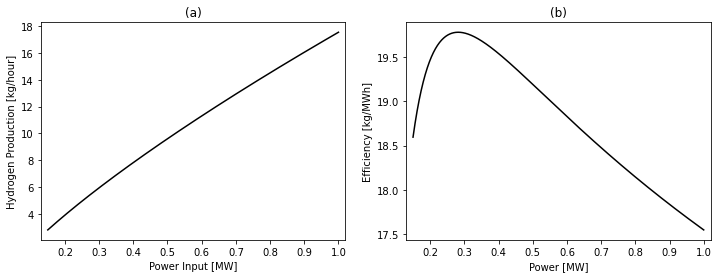

In [12]:
n_c = n_cell(5000,A_cell,1,90,30)
print(n_c)
H=M_H_sys(90,II,II*A_cell,n_c)
P=np.linspace(0.15,1,num=1000)
#plt.plot(P,H)
def M_H_cell(Temp,i):
    M_H_cell = (eta_F(Temp,i) * M_H2 * i*0.2) / (2* F_const)
    M_H_cell_kg_h = M_H_cell * 3.6
    return M_H_cell_kg_h
Z=np.polyfit(P,H,1)
print(Z)
print(np.argmax(H/P))
H_lin=Z[0]*P+Z[1]
print(np.sqrt(np.mean(H**2-H_lin**2)))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(P,H,color='k')
ax1.set_ylabel('Hydrogen Production [kg/hour]')
ax1.set_xlabel('Power Input [MW]')
ax1.set_title('(a)')
ax1.set_xlim((0.13,1.02))
ax2.plot(P,H/P,color='k')
ax2.set_ylabel('Efficiency [kg/MWh]')
ax2.set_xlabel('Power Input [MW]')
ax2.set_title('(b)')
ax2.set_xlim((0.13,1.02))
#plt.plot(P,H_lin/P,label='Linear Model')
plt.xlabel('Power [MW]')
#plt.xlim([0.15,1])


In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(P,H-H,color='k',label='Semi-emperical Model')
ax1.plot(P,Z[0]*P+Z[1]-H,color='b',label='Binary Variable Method')
#ax1.plot(P,Z1[0]*P+Z1[1]-H,color='r',label='Semi-continuous Variable Method')
ax1.set_xlim((0.13,1.02))
ax1.set_xlabel('Power [MW]')
ax1.set_ylabel('Hydrogen Production Error [kg/hour]')
ax1.legend()
ax1.set_title('(a)')
for i in range(0,5):
    x=time_semic[i]
    y=time_2state[i]
    for j in range(0,5-i):
        if i==0 and j==0:
            ax2.plot(i+1,x[j],'.',color='red',label='Semi-Continious Variable')
            ax2.plot(i+1,y[j],'.',color='blue',label='Binary Variable')
        else:
            ax2.plot(i+1,x[j],'.',color='red')
            ax2.plot(i+1,y[j],'.',color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('Simulation Time [seconds]')
ax2.set_xlabel('Optimization Time Horizon [years]')
ax2.legend()
ax2.set_title('(b)')

NameError: name 'P' is not defined

In [3]:
def H_true (P,H,P_ele,E):
    H2_true=np.zeros((len(P_ele),))
    for i in range(len(H2_true)):
        H2_true[i]=1e-3*E*np.interp(P_ele[i]/E, P, H)
    return H2_true
def lin_reg (P,H):
    Z_0,Z_1=np.polyfit(P,H,1)
    return 1e-3*Z_0,1e-3*Z_1

def lin_reg_semic (P,H):
    import numpy as np
    N=list(range(len(P)))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('QP')
    model.modelSense = GRB.MINIMIZE
    eff = model.addVar(vtype='C',lb=0,ub=50) # Power generation of every unit g for every time step t
    K = model.addVar(vtype='C',lb=-5,ub=50) # Power generation of every unit g for every time step t
    H_prod = model.addVars(N,vtype='C',lb=0,ub=20)
    model.addConstrs((H_prod[n]==eff*P[n]+K for n in N), name='Emissions')
    model.addConstr((0.01*eff+K==0), name='Emissions')
    total_cost = model.setObjective(sum((H_prod[n]-H[n])**2 for n in N))
    model.Params.LogToConsole = 0
    model.optimize()
    return 1e-3*eff.X,1e-3*K.X


def pw_reg_bin (P,H):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    import piecewise_regression
    pw_fit = piecewise_regression.Fit(P, H, n_breakpoints=9)
    pw_results = pw_fit.get_results()
    eff1 = pw_results["estimates"]["alpha1"]["estimate"]
    eff2 = pw_results["estimates"]["alpha2"]["estimate"]
    eff3 = pw_results["estimates"]["alpha3"]["estimate"]
    eff4 = pw_results["estimates"]["alpha4"]["estimate"]
    eff5 = pw_results["estimates"]["alpha5"]["estimate"]
    eff6 = pw_results["estimates"]["alpha6"]["estimate"]
    eff7 = pw_results["estimates"]["alpha7"]["estimate"]
    eff8 = pw_results["estimates"]["alpha8"]["estimate"]
    eff9 = pw_results["estimates"]["alpha9"]["estimate"]
    eff10 = pw_results["estimates"]["alpha10"]["estimate"]
    Efficiency=np.array([eff1,eff2,eff3,eff4,eff5,eff6,eff7,eff8,eff9,eff10])
    K1 = pw_results["estimates"]["const"]["estimate"]
    B1 = pw_results["estimates"]["breakpoint1"]["estimate"]
    B2 = pw_results["estimates"]["breakpoint2"]["estimate"]
    B3 = pw_results["estimates"]["breakpoint3"]["estimate"]
    B4 = pw_results["estimates"]["breakpoint4"]["estimate"]
    B5 = pw_results["estimates"]["breakpoint5"]["estimate"]
    B6 = pw_results["estimates"]["breakpoint6"]["estimate"]
    B7 = pw_results["estimates"]["breakpoint7"]["estimate"]
    B8 = pw_results["estimates"]["breakpoint8"]["estimate"]
    B9 = pw_results["estimates"]["breakpoint9"]["estimate"]
    B=np.array([0.15,B1,B2,B3,B4,B5,B6,B7,B8,B9,1])
    K2=eff1*B1+K1-eff2*B1
    K3=eff2*B2+K2-eff3*B2
    K4=eff3*B3+K3-eff4*B3
    K5=eff4*B4+K4-eff5*B4
    K6=eff5*B5+K5-eff6*B5
    K7=eff6*B6+K6-eff7*B6
    K8=eff7*B7+K7-eff8*B7
    K9=eff8*B8+K8-eff9*B8
    K10=eff9*B9+K9-eff10*B9
    K=np.array([K1,K2,K3,K4,K5,K6,K7,K8,K9,K10])
    return 1e-3*Efficiency, 1e-3*K, B

def pw_reg_lin (P,H):
    import numpy as np
    from scipy.optimize import curve_fit
    import piecewise_regression
    pw_fit = piecewise_regression.Fit(P, H, n_breakpoints=9)
    pw_results = pw_fit.get_results()
    eff1 = pw_results["estimates"]["alpha1"]["estimate"]
    eff2 = pw_results["estimates"]["alpha2"]["estimate"]
    eff3 = pw_results["estimates"]["alpha3"]["estimate"]
    eff4 = pw_results["estimates"]["alpha4"]["estimate"]
    eff5 = pw_results["estimates"]["alpha5"]["estimate"]
    eff6 = pw_results["estimates"]["alpha6"]["estimate"]
    eff7 = pw_results["estimates"]["alpha7"]["estimate"]
    eff8 = pw_results["estimates"]["alpha8"]["estimate"]
    eff9 = pw_results["estimates"]["alpha9"]["estimate"]
    eff10 = pw_results["estimates"]["alpha10"]["estimate"]
    Efficiency=np.array([eff1,eff2,eff3,eff4,eff5,eff6,eff7,eff8,eff9,eff10])
    K = pw_results["estimates"]["const"]["estimate"]
    B1 = pw_results["estimates"]["breakpoint1"]["estimate"]
    B2 = pw_results["estimates"]["breakpoint2"]["estimate"]
    B3 = pw_results["estimates"]["breakpoint3"]["estimate"]
    B4 = pw_results["estimates"]["breakpoint4"]["estimate"]
    B5 = pw_results["estimates"]["breakpoint5"]["estimate"]
    B6 = pw_results["estimates"]["breakpoint6"]["estimate"]
    B7 = pw_results["estimates"]["breakpoint7"]["estimate"]
    B8 = pw_results["estimates"]["breakpoint8"]["estimate"]
    B9 = pw_results["estimates"]["breakpoint9"]["estimate"]
    B=np.array([B1,B2-B1,B3-B2,B4-B3,B5-B4,B6-B5,B7-B6,B8-B7,B9-B8,1-B9])
    return 1e-3*Efficiency, 1e-3*K, B


def pw_reg_semic (P,H):
    import numpy as np
    eff,k,b=pw_reg_bin(P,H)
    B1 = b[1]-0.15
    B2 = b[2]-0.15
    B3 = b[3]-0.15
    B4 = b[4]-0.15
    B5 = b[5]-0.15
    B6 = b[6]-0.15
    B7 = b[7]-0.15
    B8 = b[8]-0.15
    B9 = b[9]-0.15
    inc=0.85/1000
    N=list(range(1000))
    N1=list(range(int(B1/inc)))
    N2=list(range(int(B1/inc),int(B2/inc)))
    N3=list(range(int(B2/inc),int(B3/inc)))
    N4=list(range(int(B3/inc),int(B4/inc)))
    N5=list(range(int(B4/inc),int(B5/inc)))
    N6=list(range(int(B5/inc),int(B6/inc)))
    N7=list(range(int(B6/inc),int(B7/inc)))
    N8=list(range(int(B7/inc),int(B8/inc)))
    N9=list(range(int(B8/inc),int(B9/inc)))
    N10=list(range(int(B9/inc),1000))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('MIP')
    model.modelSense = GRB.MINIMIZE
    eff1 = model.addVar(vtype='C',lb=0,ub=50)
    eff2 = model.addVar(vtype='C',lb=0,ub=50) 
    eff3 = model.addVar(vtype='C',lb=0,ub=50) 
    eff4 = model.addVar(vtype='C',lb=0,ub=50) 
    eff5 = model.addVar(vtype='C',lb=0,ub=50) 
    eff6 = model.addVar(vtype='C',lb=0,ub=50) 
    eff7 = model.addVar(vtype='C',lb=0,ub=50) 
    eff8 = model.addVar(vtype='C',lb=0,ub=50) 
    eff9 = model.addVar(vtype='C',lb=0,ub=50) 
    eff10 = model.addVar(vtype='C',lb=0,ub=50) 
    K = model.addVar(vtype='C',lb=-5,ub=5) # Power generation of every unit g for every time step t
    H_prod = model.addVars(N,vtype='C',lb=0,ub=20)

    model.addConstrs((H_prod[n]==eff1*P[n]+K for n in N1), name='Emissions')
    model.addConstrs((H_prod[n]==eff2*(P[n]-P[N1[-1]])+H_prod[N1[-1]] for n in N2))
    model.addConstrs((H_prod[n]==eff3*(P[n]-P[N2[-1]])+H_prod[N2[-1]] for n in N3))
    model.addConstrs((H_prod[n]==eff4*(P[n]-P[N3[-1]])+H_prod[N3[-1]] for n in N4))
    model.addConstrs((H_prod[n]==eff5*(P[n]-P[N4[-1]])+H_prod[N4[-1]] for n in N5))
    model.addConstrs((H_prod[n]==eff6*(P[n]-P[N5[-1]])+H_prod[N5[-1]] for n in N6))
    model.addConstrs((H_prod[n]==eff7*(P[n]-P[N6[-1]])+H_prod[N6[-1]] for n in N7))
    model.addConstrs((H_prod[n]==eff8*(P[n]-P[N7[-1]])+H_prod[N7[-1]] for n in N8))
    model.addConstrs((H_prod[n]==eff9*(P[n]-P[N8[-1]])+H_prod[N8[-1]] for n in N9))
    model.addConstrs((H_prod[n]==eff10*(P[n]-P[N9[-1]])+H_prod[N9[-1]] for n in N10))

    model.addConstr((eff1>=eff2+1e-3))
    model.addConstr((eff2>=eff3+1e-3))
    model.addConstr((eff3>=eff4+1e-3))
    model.addConstr((eff4>=eff5+1e-3))
    model.addConstr((eff5>=eff6+1e-3))
    model.addConstr((eff6>=eff7+1e-3))
    model.addConstr((eff7>=eff8+1e-3))
    model.addConstr((eff8>=eff9+1e-3))
    model.addConstr((eff9>=eff10+1e-3))
    
    model.addConstr((0.01*eff1+K==0))

    total_cost = model.setObjective(sum((H_prod[n]-H[n])**2 for n in N))

    model.Params.LogToConsole = 0

    model.optimize()
    obj = model.getObjective()
    Efficiency=np.array([eff1.X,eff2.X,eff3.X,eff4.X,eff5.X,eff6.X,eff7.X,eff8.X,eff9.X,eff10.X])
    K=K.X
    B=np.array([B1+0.15,B2-B1,B3-B2,B4-B3,B5-B4,B6-B5,B7-B6,B8-B7,B9-B8,1-B9-0.15])
    return 1e-3*Efficiency, 1e-3*K, B

def pw_reg_bin6 (P,H):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    import piecewise_regression
    pw_fit = piecewise_regression.Fit(P, H, n_breakpoints=5)
    pw_results = pw_fit.get_results()
    eff1 = pw_results["estimates"]["alpha1"]["estimate"]
    eff2 = pw_results["estimates"]["alpha2"]["estimate"]
    eff3 = pw_results["estimates"]["alpha3"]["estimate"]
    eff4 = pw_results["estimates"]["alpha4"]["estimate"]
    eff5 = pw_results["estimates"]["alpha5"]["estimate"]
    eff6 = pw_results["estimates"]["alpha6"]["estimate"]
    Efficiency=np.array([eff1,eff2,eff3,eff4,eff5,eff6])
    K1 = pw_results["estimates"]["const"]["estimate"]
    B1 = pw_results["estimates"]["breakpoint1"]["estimate"]
    B2 = pw_results["estimates"]["breakpoint2"]["estimate"]
    B3 = pw_results["estimates"]["breakpoint3"]["estimate"]
    B4 = pw_results["estimates"]["breakpoint4"]["estimate"]
    B5 = pw_results["estimates"]["breakpoint5"]["estimate"]
    B=np.array([0.15,B1,B2,B3,B4,B5,1])
    K2=eff1*B1+K1-eff2*B1
    K3=eff2*B2+K2-eff3*B2
    K4=eff3*B3+K3-eff4*B3
    K5=eff4*B4+K4-eff5*B4
    K6=eff5*B5+K5-eff6*B5
    K=np.array([K1,K2,K3,K4,K5,K6])
    return 1e-3*Efficiency, 1e-3*K, B

def pw_reg_semic6 (P,H):
    import numpy as np
    eff,k,b=pw_reg_bin6(P,H)
    B1 = b[1]-0.15
    B2 = b[2]-0.15
    B3 = b[3]-0.15
    B4 = b[4]-0.15
    B5 = b[5]-0.15
    inc=0.85/1000
    N=list(range(1000))
    N1=list(range(int(B1/inc)))
    N2=list(range(int(B1/inc),int(B2/inc)))
    N3=list(range(int(B2/inc),int(B3/inc)))
    N4=list(range(int(B3/inc),int(B4/inc)))
    N5=list(range(int(B4/inc),int(B5/inc)))
    N6=list(range(int(B5/inc),1000))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('MIP')
    model.modelSense = GRB.MINIMIZE
    eff1 = model.addVar(vtype='C',lb=0,ub=50)
    eff2 = model.addVar(vtype='C',lb=0,ub=50) 
    eff3 = model.addVar(vtype='C',lb=0,ub=50) 
    eff4 = model.addVar(vtype='C',lb=0,ub=50) 
    eff5 = model.addVar(vtype='C',lb=0,ub=50) 
    eff6 = model.addVar(vtype='C',lb=0,ub=50) 
    K = model.addVar(vtype='C',lb=-5,ub=5) # Power generation of every unit g for every time step t
    H_prod = model.addVars(N,vtype='C',lb=0,ub=20)

    model.addConstrs((H_prod[n]==eff1*P[n]+K for n in N1), name='Emissions')
    model.addConstrs((H_prod[n]==eff2*(P[n]-P[N1[-1]])+H_prod[N1[-1]] for n in N2))
    model.addConstrs((H_prod[n]==eff3*(P[n]-P[N2[-1]])+H_prod[N2[-1]] for n in N3))
    model.addConstrs((H_prod[n]==eff4*(P[n]-P[N3[-1]])+H_prod[N3[-1]] for n in N4))
    model.addConstrs((H_prod[n]==eff5*(P[n]-P[N4[-1]])+H_prod[N4[-1]] for n in N5))
    model.addConstrs((H_prod[n]==eff6*(P[n]-P[N5[-1]])+H_prod[N5[-1]] for n in N6))

    model.addConstr((eff1>=eff2+1e-3))
    model.addConstr((eff2>=eff3+1e-3))
    model.addConstr((eff3>=eff4+1e-3))
    model.addConstr((eff4>=eff5+1e-3))
    model.addConstr((eff5>=eff6+1e-3))
    
    model.addConstr((0.01*eff1+K==0))

    total_cost = model.setObjective(sum((H_prod[n]-H[n])**2 for n in N))

    model.Params.LogToConsole = 0

    model.optimize()
    obj = model.getObjective()
    Efficiency=np.array([eff1.X,eff2.X,eff3.X,eff4.X,eff5.X,eff6.X])
    K=K.X
    B=np.array([B1+0.15,B2-B1,B3-B2,B4-B3,B5-B4,1-B5-0.15])
    return 1e-3*Efficiency, 1e-3*K, B

In [15]:
MP_simulation=[[MP_raw[0],MP_raw[1],MP_raw[2],MP_raw[3],MP_raw[4]], \
               [[*MP_raw[0],*MP_raw[1]],[*MP_raw[1],*MP_raw[2]],[*MP_raw[2],*MP_raw[3]],[*MP_raw[3],*MP_raw[4]]], \
               [[*MP_raw[0],*MP_raw[1],*MP_raw[2]],[*MP_raw[1],*MP_raw[2],*MP_raw[3]],[*MP_raw[2],*MP_raw[3],*MP_raw[4]]],\
               [[*MP_raw[0],*MP_raw[1],*MP_raw[2],*MP_raw[3]],[*MP_raw[1],*MP_raw[2],*MP_raw[3],*MP_raw[4]]],\
               [*MP_raw[0],*MP_raw[1],*MP_raw[2],*MP_raw[3],*MP_raw[4]]]

# 0. Testing the iteration results

In [37]:
Z0_it=np.zeros((10,20))
Z1_it=np.zeros((10,20))
import random
Z_0,Z_1=lin_reg (P,H)
MP=MP_simulation[0][4] #2023
#Linear Simulation
for i in range(0,20):
    Z0_val=np.zeros((10,))
    Z1_val=np.zeros((10,))
    Z0_val[0]=Z_0*(1+0.01*random.randint(-25, 25))
    Z1_val[0]=Z_1*(1+0.01*random.randint(-200, 200))
    for j in range(0,10):
        Z0=Z0_val[j]
        Z1=Z1_val[j]
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2.5
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == Z0*P_ele[t]+Z1*E for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        P_res=np.array(model.getAttr('X',P_ele.values()))
        H2_true=H_true(P,H,P_res,E)
        Z0_val[j+1],Z1_val[j+1]=lin_reg (P_res,1e3*H2_true)
        if abs(Z0_val[j]-Z0_val[j-1])<=1e-3*Z0_val[j-1] and abs(Z1_val[j]-Z1_val[j-1])<=1e-3*Z1_val[j-1]:
            break
    Z0_it[:,i]=Z0_val
    Z1_it[:,i]=Z1_val


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# 1.a Linear - No Feedback

In [106]:
import time
time_linear_nofeedback=np.zeros((5,5))
Z0,Z1=lin_reg (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2.5
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == Z0*P_ele[t]+Z1*E for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
        if i==0 and j==4:
            obj=model.getObjective()
            obj_linear_nofeedback = obj.getValue()
            P_linear_nofeedback=np.array(model.getAttr('X',P_ele.values()))
    time_linear_nofeedback[:,i]=time_sim
    print(i)

0
1
2
3
4


# 1.b Linear - Feedback

In [266]:
import time
time_linear_feedback=np.zeros((5,5))
Z_0,Z_1=lin_reg (P,H)
#Linear Simulation
for i in [0,4]:
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        Z0_val=np.zeros((10,))
        Z1_val=np.zeros((10,))
        Z0_val[0]=Z_0
        Z1_val[0]=Z_1
        for m in range(0,10):
            Z0=Z0_val[m]
            Z1=Z1_val[m]
            T = list(range(len(MP)))
            from gurobipy import Model,GRB,quicksum
            import gurobipy as gp
            model = Model('CVRP')
            model.modelSense = GRB.MINIMIZE
            Ann_E=0.1 # Annualization coefficient of the electrolysis plant
            Ann_C=0.1 # Annualization coefficient of the storage facility
            C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
            E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
            DH2=0.1
            # Optimization variables
            C = 2
            E = 12
            S_in = model.addVar(vtype='C', lb=0, ub=1e5)
            S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
            P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
            H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
            P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
            En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
            model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

            model.addConstrs((H2_gen[t] == Z0*P_ele[t]+Z1 for t in T), name='H2 Direct')

            model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

            model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

            model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

            model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

            model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

            model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

            model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

            model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

            model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

            model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


            Total_cost = model.setObjective(sum(En_C[t] for t in T))
            #Optimization constraints
            model.Params.OutputFlag = 0
            model.setParam('TimeLimit', 2000)
            model.optimize()
            P_res=np.array(model.getAttr('X',P_ele.values()))
            H2_true=H_true(P,H,P_res,E)
            Z0_val[m+1],Z1_val[m+1]=lin_reg (P_res,1e3*H2_true)
            if abs(Z0_val[m]-Z0_val[m-1])<=1e-2*Z0_val[m-1] and abs(Z1_val[m]-Z1_val[m-1])<=1e-2*Z1_val[m-1]:
                break
        end_time = time.time()
        time_sim[j]=end_time-start_time
        if i==0 and j==4:
            obj=model.getObjective()
            obj_linear_feedback = obj.getValue()
            P_linear_feedback=np.array(model.getAttr('X',P_ele.values()))
            Z0_2023=Z0_val[m]
            Z1_2023=Z1_val[m]
    time_linear_feedback[:,i]=time_sim
    print(i)

0
4


In [126]:
H2_true_nofeedback=H_true(P,H,P_linear_nofeedback,E)
H2_true_feedback=H_true(P,H,P_linear_feedback,E)
H2_sim_nofeedback=Z_0*P_linear_nofeedback+Z_1
H2_sim_feedback=Z0_2023*P_linear_feedback+Z1_2023
bias_nofeedback=100*(sum(H2_sim_nofeedback)-sum(H2_true_nofeedback))/sum(H2_true_nofeedback)
bias_feedback=100*(sum(H2_sim_feedback)-sum(H2_true_feedback))/sum(H2_true_feedback)
print(bias_nofeedback,bias_feedback)
rmsd_feedback=np.sqrt(np.mean((H2_true_feedback-H2_sim_feedback)**2))
rmsd_nofeedback=np.sqrt(np.mean((H2_true_nofeedback-H2_sim_nofeedback)**2))
print(1e3*rmsd_feedback,1e3*rmsd_nofeedback)
print(obj_linear_nofeedback)
print(obj_linear_feedback)


-3.666988656435926 -1.3940945179223571e-05
2.544402731242148 4.395789756905178
3296.22162954553
3575.621759014597


In [204]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax11=ax1.twinx()
Z_0,Z_1=lin_reg (P,H)
ax11.hist(P_linear_feedback, bins=50,align='mid', color='skyblue', alpha=0.5, edgecolor='black')
ax1.plot([E*0.15,E],[0,0],color='black',label='Reference Model')
ax1.plot(12*np.array(P),H-1e3*(Z_0*np.array(P)+Z_1),color='blue',label='WO Feedback')
ax1.plot(12*np.array(P),H-1e3*(Z0_2023*np.array(P)+Z1_2023/E),color='red',label='With Feedback')
ax1.legend()
ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
ax11.set_ylabel('Frequency',FontSize=12)
#plt.plot(P_res,H2_true-H2_gen,'.')
print(np.shape(time_linear_feedback))
for i in range(0,5):
    t1= time_linear_nofeedback[:,i]
    t2= time_linear_feedback[:,i]
    for j in range(0,5-i):
        if i==4:
            ax2.plot(i+1,t1[j],'.',color='red', label='WO Feedback')
            ax2.plot(i+1,t2[j],'.',color='blue', label='With Feedback')
        else:
            ax2.plot(i+1,t1[j],'.',color='red')
            ax2.plot(i+1,t2[j],'.',color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
ax2.set_xlabel('Optimization Time Horizon [years]',FontSize=12)
ax2.legend()
plt.tight_layout()


<ipython-input-204-9809e049f430>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
<ipython-input-204-9809e049f430>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
<ipython-input-204-9809e049f430>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax11.set_ylabel('Frequency',FontSize=12)
<ipython-input-204-9809e049f430>:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
<ipython-input-204-9809e049f430>:26: MatplotlibDeprecationWarning: Case-insensitive properti

(5, 5)


# 2.a Operating States - Binary

In [272]:
import time
time_binary=np.zeros((5,5))
Z_0,Z_1=lin_reg (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        State = model.addVars(T, vtype=GRB.BINARY)

        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == State[t]*(Z0*P_ele[t]+Z1) for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.01*E+State[t]*0.14*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_binary= obj.getValue()
        P_binary=np.array(model.getAttr('X',P_ele.values()))
    time_binary[:,i]=time_sim
    print(i)

0
1
2
3
4


# 2.b Operating States - Semi-continuous

In [80]:
import time
time_semic=np.zeros((5,5))
Z_0,Z_1=lin_reg_semic (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='S', lb=0.15*E*Z_0+Z_1*E, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == (Z_0*P_ele[t]+Z_1*E) for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_semic= obj.getValue()
        P_semic=np.array(model.getAttr('X',P_ele.values()))
    time_semic[:,i]=time_sim
    print(i)

0
1
2
3
4


In [207]:
H2_true_binary=H_true(P,H,P_binary,E)
H2_true_semic=H_true(P,H,P_semic,E)
Z_0,Z_1=lin_reg (P,H)
H2_sim_binary=Z_0*P_binary+Z_1
Z_0,Z_1=lin_reg_semic (P,H)
H2_sim_semic=Z_0*P_semic+Z_1
bias_binary=100*(sum(H2_sim_binary)-sum(H2_true_binary))/sum(H2_true_binary)
bias_feedback=100*(sum(H2_sim_semic)-sum(H2_true_semic))/sum(H2_true_semic)
print(bias_nofeedback,bias_feedback)
rmsd_binary=np.sqrt(np.mean((H2_true_binary-H2_sim_binary)**2))
rmsd_semic=np.sqrt(np.mean((H2_true_semic-H2_sim_semic)**2))
print(1e3*rmsd_feedback,1e3*rmsd_nofeedback)
print(obj_binary)
print(obj_semic)


-3.666988656435926 -9.582332014143851
2.544402731242148 4.395789756905178
3420.6343647453214
3334.0780398130223


<ipython-input-273-7bb42616a57d>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
<ipython-input-273-7bb42616a57d>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
<ipython-input-273-7bb42616a57d>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
<ipython-input-273-7bb42616a57d>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_xlabel('Optimization Time Horizon [years]',FontSize=12)


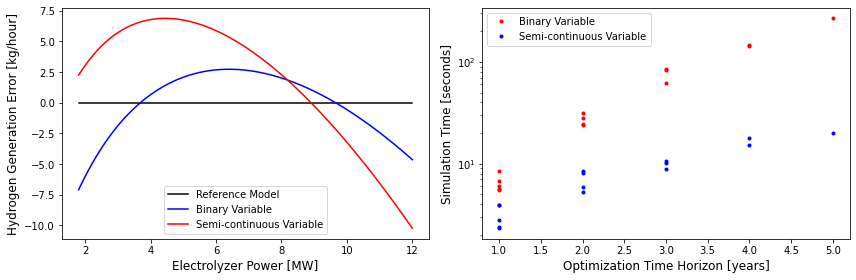

In [273]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot([E*0.15,E],[0,0],color='black',label='Reference Model')
Z_0,Z_1=lin_reg (P,H)
ax1.plot(12*np.array(P),12*(H-1e3*(Z_0*np.array(P)+Z_1)),color='blue',label='Binary Variable')
Z_0,Z_1=lin_reg_semic (P,H)
ax1.plot(12*np.array(P),12*(H-1e3*(Z_0*np.array(P)+Z_1)),color='red',label='Semi-continuous Variable')
ax1.legend()
ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
#plt.plot(P_res,H2_true-H2_gen,'.')
for i in range(0,5):
    t1= time_binary[:,i]
    t2= time_semic[:,i]
    for j in range(0,5-i):
        if i==4:
            ax2.plot(i+1,t1[j],'.',color='red', label='Binary Variable')
            ax2.plot(i+1,t2[j],'.',color='blue', label='Semi-continuous Variable')
        else:
            ax2.plot(i+1,t1[j],'.',color='red')
            ax2.plot(i+1,t2[j],'.',color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
ax2.set_xlabel('Optimization Time Horizon [years]',FontSize=12)
ax2.legend()
plt.tight_layout()


# 3.a PW with Binary

In [20]:
import time
time_pw_lin=np.zeros((5,5))
eff,K,B=pw_reg_bin (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        N = list(range(10))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        S = model.addVars(N,T, vtype=GRB.BINARY)
        
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)
        
        for n in N:
    
            model.addConstrs((S[n,t]*B_val[n] <= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)
            model.addConstrs((S[n,t]*B_val[n+1] >= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((P_ele[t] == sum(S[n,t]*P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)
    
        model.addConstrs((H2_gen[t] == (sum(S[n,t]*(eff[n]*P_seg[n,t]+ K[n]*E) for n in N)) for t in T), name='H2 Direct')
    
        model.addConstrs((sum(S[n,t] for n in N) ==1  for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 300)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_pw_bin= obj.getValue()
        P_pw_bin=np.array(model.getAttr('X',P_ele.values()))
    time_pw_bin[:,i]=time_sim
    print(i)

TypeError: 'int' object is not subscriptable

# 3.b PW without Binary

In [58]:
import time
time_pw_lin=np.zeros((5,5))
eff,K,B=pw_reg_lin (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        N = list(range(10))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)
        
        for n in N:
            model.addConstrs((P_seg[n,t] <= E*B[n] for t in T), name='H2 Direct')
        for n in range(0,9):
            model.addConstrs((P_seg[n,t]/B[n] >= P_seg[n+1,t]/B[n+1] for t in T), name='H2 Direct')

        model.addConstrs((P_ele[t] == sum(P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)
    
        model.addConstrs((H2_gen[t] == sum(eff[n]*P_seg[n,t] for n in N) +K*E for t in T), name='H2 Direct')
    
        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 300)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_pw_lin= obj.getValue()
        P_pw_lin=np.array(model.getAttr('X',P_ele.values()))
        H_pw_lin=np.array(model.getAttr('X',H2_gen.values()))
    time_pw_lin[:,i]=time_sim
    print(i)

0
1
2
3
4


<ipython-input-57-286ead20242b>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
<ipython-input-57-286ead20242b>:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
<ipython-input-57-286ead20242b>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_title('(a)', FontSize=14)
<ipython-input-57-286ead20242b>:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
<ipython-input-57-286ead20242b>:36: MatplotlibDeprecationWarning: Case-insensitive properties were dep

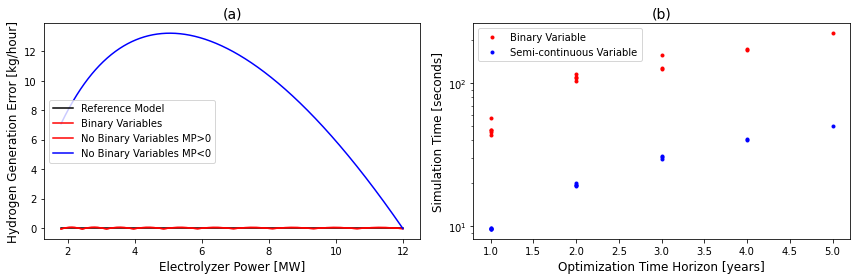

In [57]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot([E*0.15,E],[0,0],color='black',label='Reference Model')
eff,K,B=pw_reg_bin (P,H)
H_pw_sim=np.zeros((len(P),))
for i in range(len(P)):
    for n in range(0,10):
        if P[i]>=B[n] and P[i]<=B[n+1]:
            H_pw_sim[i]=eff[n]*P[i]+K[n]
            break
ax1.plot(12*np.array(P),E*(H-1e3*(H_pw_sim)),color='red',label='Binary Variables')
ax1.plot(12*np.array(P),E*(H-1e3*(H_pw_sim)),color='red',label='No Binary Variables MP>0')

eff,K,B=pw_reg_lin (P,H)
Eff=(sum(eff*B))
ax1.plot(12*np.array(P),12*(H-1e3*(Eff*P+K)),color='blue',label='No Binary Variables MP<0')

#Z_0,Z_1=lin_reg_semic (P,H)
#ax1.plot(12*np.array(P),H-1e3*(Z_0*np.array(P)+Z_1),color='red',label='Semi-continuous Variable')
ax1.legend()
ax1.set_xlabel('Electrolyzer Power [MW]',FontSize=12)
ax1.set_ylabel('Hydrogen Generation Error [kg/hour]',FontSize=12)
ax1.set_title('(a)', FontSize=14)
#plt.plot(P_res,H2_true-H2_gen,'.')
for i in range(0,5):
    t1= time_pw_bin[:,i]
    t2= time_pw_lin[:,i]
    for j in range(0,5-i):
        if i==4:
            ax2.plot(i+1,t1[j],'.',color='red', label='Binary Variable')
            ax2.plot(i+1,t2[j],'.',color='blue', label='Semi-continuous Variable')
        else:
            ax2.plot(i+1,t1[j],'.',color='red')
            ax2.plot(i+1,t2[j],'.',color='blue')
ax2.set_yscale('log')
ax2.set_ylabel('Simulation Time [seconds]',FontSize=12)
ax2.set_xlabel('Optimization Time Horizon [years]',FontSize=12)
ax2.legend()
ax2.set_title('(b)', FontSize=14)

plt.tight_layout()


In [65]:
H2_true_pwb=H_true(P,H,P_pw_bin,E)
H2_true_pwl=H_true(P,H,P_pw_lin,E)
H2_sim_pwl=H_pw_sim
eff,K,B=pw_reg_bin (P,H)

H2_sim_pwb=np.zeros((len(P_pw_bin),))
for i in range(len(P)):
    for n in range(0,10):
        if P_pw_bin[i]>=E*B[n] and P_pw_bin[i]<=E*B[n+1]:
            H2_sim_pwb[i]=eff[n]*P_pw_bin[i]+K[n]
            break
bias_pwb=100*(sum(H2_sim_pwb)-sum(H2_true_pwb))/sum(H2_true_pwb)
bias_pwl=100*(sum(H_pw_lin)-sum(H2_true_pwl))/sum(H2_true_pwl)
print(bias_pwb,bias_pwl)
rmsd_pwb=np.sqrt(np.mean((H2_true_pwb-H2_sim_pwb)**2))
rmsd_pwl=np.sqrt(np.mean((H2_true_pwl-H_pw_lin)**2))
print(1e3*rmsd_pwb,1e3*rmsd_pwl)
print(obj_pw_bin)
print(obj_pw_lin)


-89.54874889931709 0.05706686610274144
111.85947135212503 0.06232732719448829
3489.669386478858
3489.488743503823


# 4.a Common Model

In [70]:
import time
time_common=np.zeros((5,5))
eff,K,B=pw_reg_bin (P,H)
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        N = list(range(10))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        S = model.addVars(N,T, vtype=GRB.BINARY)
        State = model.addVars(T, vtype=GRB.BINARY)
        
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)
        
        for n in N:
    
            model.addConstrs((S[n,t]*B[n]*E <= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)
            model.addConstrs((S[n,t]*B[n+1]*E >= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((P_ele[t] == sum(S[n,t]*P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)
    
        model.addConstrs((H2_gen[t] == (sum(S[n,t]*(eff[n]*P_seg[n,t]+ K[n]*E) for n in N)) for t in T), name='H2 Direct')
    
        model.addConstrs((sum(S[n,t] for n in N) == State[t] for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= (0.15*State[t]+0.01*(1-State[t]))*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 600)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_common= obj.getValue()
        P_common=np.array(model.getAttr('X',P_ele.values()))
        H2_common=np.array(model.getAttr('X',H2_gen.values()))
    time_common[:,i]=time_sim
    print(i)

0
1
2
3
4


# 4.b Proposed Model

In [77]:
eff,K,B=pw_reg_semic (P,H)
import time
time_new=np.zeros((5,5))
#Linear Simulation
for i in range(0,5):
    time_sim=np.zeros((5,))
    for j in range(0,5-i):
        MP=MP_simulation[i][j]
        if i==4:
              MP=MP_simulation[4]  
        start_time = time.time()
        T = list(range(len(MP)))
        N = list(range(10))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = 2
        E = 12
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='S', lb=E*(0.15*eff[0]+K), ub=10)
        P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
        
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)
        
        for n in N:
            model.addConstrs((P_seg[n,t] <= E*B[n] for t in T), name='H2 Direct')
        for n in range(0,9):
            model.addConstrs((P_seg[n,t]/B[n] >= P_seg[n+1,t]/B[n+1] for t in T), name='H2 Direct')

        model.addConstrs((P_ele[t] == sum(P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)
    
        model.addConstrs((H2_gen[t] == sum(eff[n]*P_seg[n,t] for n in N) +K*E for t in T), name='H2 Direct')
    
        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 300)
        model.optimize()
        end_time = time.time()
        time_sim[j]=end_time-start_time
    if i==0 and j==4:
        obj=model.getObjective()
        obj_new= obj.getValue()
        P_new=np.array(model.getAttr('X',P_ele.values()))
        H_new=np.array(model.getAttr('X',H2_gen.values()))
    time_new[:,i]=time_sim
    print(i)

0
1
2
3
4


# 5. Capacity Optimization

# a. Linear Feedback

In [21]:
import time
Z_0,Z_1=lin_reg (P,H)
CO_LF_T=np.zeros((5,))
CO_LF_C=np.zeros((5,))
CO_LF_E=np.zeros((5,))
CO_LF_OF=np.zeros((5,))

for i in range(0,5):
    MP=MP_simulation[0][i]  
    start_time = time.time()
    C_val=np.zeros((10,))
    E_val=np.zeros((10,))
    Z0_val=np.zeros((10,))
    Z1_val=np.zeros((10,))
    C_val[0]=5
    E_val[0]=14
    Z0_val[0]=Z_0
    Z1_val[0]=Z_1*E_val[0]
    for m in range(0,10):
        Z0=Z0_val[m]
        Z1=Z1_val[m]
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = model.addVar(vtype='C', lb=0, ub=1e5)
        E = model.addVar(vtype='C', lb=0, ub=1e5)
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
    
        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == Z0*P_ele[t]+Z1 for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        P_res=np.array(model.getAttr('X',P_ele.values()))
        H2_true=H_true(P,H,P_res,E.X)
        Z0_val[m+1],Z1_val[m+1]=lin_reg (P_res,1e3*H2_true)
        C_val[m+1]=C.X
        E_val[m+1]=E.X
        if abs(C_val[m+1]-C_val[m])<=1e-3*C_val[m] and abs(E_val[m+1]-E_val[m])<=1e-3*E_val[m]:
            break
        print(m)
    end_time = time.time()
    CO_LF_T[i]=end_time-start_time
    CO_LF_C[i]=C.X
    CO_LF_E[i]=E.X
    obj=model.getObjective()
    CO_LF_OF[i]=obj.getValue()

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


# a1. Linear No Feedback

In [64]:
import time
Z_0,Z_1=lin_reg (P,H)
CO_LNF_T=np.zeros((5,))
CO_LNF_C=np.zeros((5,))
CO_LNF_E=np.zeros((5,))
CO_LNF_OF=np.zeros((5,))

for i in range(0,5):
    MP=MP_simulation[0][i]  
    start_time = time.time()
    T = list(range(len(MP)))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('CVRP')
    model.modelSense = GRB.MINIMIZE
    Ann_E=0.1 # Annualization coefficient of the electrolysis plant
    Ann_C=0.1 # Annualization coefficient of the storage facility
    C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
    E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
    DH2=0.1
    # Optimization variables
    C = model.addVar(vtype='C', lb=0, ub=1e5)
    E = model.addVar(vtype='C', lb=0, ub=1e5)
    S_in = model.addVar(vtype='C', lb=0, ub=1e5)
    S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
    P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
    H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
    P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
    En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

    model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

    model.addConstrs((H2_gen[t] == Z_0*P_ele[t]+Z_1*E for t in T), name='H2 Direct')

    model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

    model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

    model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

    model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

    model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

    model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

    model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

    model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

    model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

    model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


    Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
    #Optimization constraints
    model.Params.OutputFlag = 0
    model.setParam('TimeLimit', 2000)
    model.optimize()
    end_time = time.time()
    CO_LNF_T[i]=end_time-start_time
    CO_LNF_C[i]=C.X
    CO_LNF_E[i]=E.X
    obj=model.getObjective()
    CO_LNF_OF[i]=obj.getValue()

# b. Semi-Continuous Feedback

In [23]:
import time
CO_SCF_T=np.zeros((5,))
CO_SCF_C=np.zeros((5,))
CO_SCF_E=np.zeros((5,))
CO_SCF_OF=np.zeros((5,))

for i in range(0,5):
    MP=MP_simulation[0][i]  
    start_time = time.time()
    C_val=np.zeros((10,))
    E_val=np.zeros((10,))
    Z0_val=np.zeros((10,))
    Z1_val=np.zeros((10,))
    Z0_val[0],Z1_val[0]=lin_reg_semic(P,H)
    C_val[0]=7
    E_val[0]=13
    #Z0_val[0]=Z_0
    #Z1_val[0]=Z_1*E_val[0]
    for m in range(0,10):
        Z0=Z_0
        Z1=Z_1*E_val
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = model.addVar(vtype='C', lb=0, ub=1e5)
        E = model.addVar(vtype='C', lb=0, ub=1e5)
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='S', lb=E_val[m]*0.15*Z_0+Z_1, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == Z0_val[m]*P_ele[t]+Z1_val[m] for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        P__=np.array(model.getAttr('X',P_ele.values()))
        P_res=P__[P__>0.15*E.X]
        H2_true=H_true(P,H,P_res,E.X)
        Z0_val[m+1],Z1_val[m+1]=lin_reg_semic (P_res/E.X,1e3*H2_true/E.X)
        C_val[m+1]=C.X
        E_val[m+1]=E.X
        print(m)
        if abs(C_val[m+1]-C_val[m])<=1e-3*C_val[m] and abs(E_val[m+1]-E_val[m])<=1e-3*E_val[m]:
            break
    end_time = time.time()
    CO_SCF_T[i]=end_time-start_time
    CO_SCF_C[i]=C.X
    CO_SCF_E[i]=E.X
    obj=model.getObjective()
    CO_SCF_OF[i]=obj.getValue()

0
1
2
0
1
2
0
1
2
3
0
1
2
0
1
2


# b1. Semi-Continuous No Feedback

In [65]:
import time
CO_SCNF_T=np.zeros((5,))
CO_SCNF_C=np.zeros((5,))
CO_SCNF_E=np.zeros((5,))
CO_SCNF_OF=np.zeros((5,))

for i in range(0,5):
    MP=MP_simulation[0][i]  
    start_time = time.time()
    Z_0,Z_1=lin_reg_semic(P,H)
    C_val[0]=7
    E_val[0]=13
    for m in range(0,10):
        T = list(range(len(MP)))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = model.addVar(vtype='C', lb=0, ub=1e5)
        E = model.addVar(vtype='C', lb=0, ub=1e5)
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='S', lb=E_val[m]*0.15*Z_0+Z_1, ub=10)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == Z_0*P_ele[t]+Z_1*E for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 2000)
        model.optimize()
        C_val[m+1]=C.X
        E_val[m+1]=E.X
        print(m)
        if abs(C_val[m+1]-C_val[m])<=1e-3*C_val[m] and abs(E_val[m+1]-E_val[m])<=1e-3*E_val[m]:
            break
    end_time = time.time()
    CO_SCNF_T[i]=end_time-start_time
    CO_SCNF_C[i]=C.X
    CO_SCNF_E[i]=E.X
    obj=model.getObjective()
    CO_SCNF_OF[i]=obj.getValue()
    print(i)

0
1
2
0
0
1
2
1
0
1
2
0
1
2
3
0
1
4


# c. PW - Linear

In [30]:
import time
CO_PW_T=np.zeros((5,))
CO_PW_C=np.zeros((5,))
CO_PW_E=np.zeros((5,))
CO_PW_OF=np.zeros((5,))
for i in range(0,5):
    MP=MP_simulation[0][i] 
    eff,K,B=pw_reg_lin (P,H)
    start_time = time.time()
    T = list(range(len(MP)))
    N = list(range(10))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('CVRP')
    model.modelSense = GRB.MINIMIZE
    Ann_E=0.1 # Annualization coefficient of the electrolysis plant
    Ann_C=0.1 # Annualization coefficient of the storage facility
    C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
    E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
    DH2=0.1
    # Optimization variables
    C = model.addVar(vtype='C', lb=0, ub=1e5)
    E = model.addVar(vtype='C', lb=0, ub=1e5)
    S_in = model.addVar(vtype='C', lb=0, ub=1e5)
    S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
    P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
    H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
    P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
    P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
    En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

    model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

    for n in N:
        model.addConstrs((P_seg[n,t] <= E*B[n] for t in T), name='H2 Direct')
    for n in range(0,9):
        model.addConstrs((P_seg[n,t]/B[n] >= P_seg[n+1,t]/B[n+1] for t in T), name='H2 Direct')

    model.addConstrs((P_ele[t] == sum(P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)

    model.addConstrs((H2_gen[t] == sum(eff[n]*P_seg[n,t] for n in N) +K*E for t in T), name='H2 Direct')

    model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

    model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

    model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

    model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

    model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

    model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

    model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

    model.addConstrs((P_ele[t] >= 0.15*E for t in T), name='Energy Consumption Limit')

    model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

    model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


    Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
    #Optimization constraints
    model.Params.OutputFlag = 0
    model.setParam('TimeLimit', 300)
    model.optimize()
    end_time = time.time()
    CO_PW_T[i]=end_time-start_time
    CO_PW_C[i]=C.X
    CO_PW_E[i]=E.X
    obj=model.getObjective()
    CO_PW_OF[i]=obj.getValue()
    print(i)

0
1
2
3
4


# d. Proposed Model

In [41]:
import time
eff,K,B=pw_reg_semic (P,H)
#CO_PM_T=np.zeros((5,))
#CO_PM_C=np.zeros((5,))
#CO_PM_E=np.zeros((5,))
#CO_PM_OF=np.zeros((5,))
for i in range(1,5):
    start_time = time.time()
    C_val=np.zeros((10,))
    E_val=np.zeros((10,))
    C_val[0]=2
    E_val[0]=10
    #Linear Simulation
    MP=MP_simulation[0][i]
    for m in range(0,10):
        T = list(range(len(MP)))
        N = list(range(10))
        from gurobipy import Model,GRB,quicksum
        import gurobipy as gp
        model = Model('CVRP')
        model.modelSense = GRB.MINIMIZE
        Ann_E=0.1 # Annualization coefficient of the electrolysis plant
        Ann_C=0.1 # Annualization coefficient of the storage facility
        C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
        E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
        DH2=0.1
        # Optimization variables
        C = model.addVar(vtype='C', lb=0, ub=1e5)
        E = model.addVar(vtype='C', lb=0, ub=1e5)
        S_in = model.addVar(vtype='C', lb=0, ub=1e5)
        S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
        P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
        H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
        H2_gen = model.addVars(T, vtype='S', lb=E_val[m]*(0.15*eff[0]+K), ub=10)
        H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
        P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
        P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
        En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)

        model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

        for n in N:
            model.addConstrs((P_seg[n,t] <= E*B[n] for t in T), name='H2 Direct')
        for n in range(0,9):
            model.addConstrs((P_seg[n,t]/B[n] >= P_seg[n+1,t]/B[n+1] for t in T), name='H2 Direct')

        model.addConstrs((P_ele[t] == sum(P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)

        model.addConstrs((H2_gen[t] == sum(eff[n]*P_seg[n,t] for n in N) +K*E for t in T), name='H2 Direct')

        model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

        model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

        model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

        model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

        model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

        model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

        model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

        model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

        model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


        Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
        #Optimization constraints
        model.Params.OutputFlag = 0
        model.setParam('TimeLimit', 500)
        model.optimize()
        C_val[m+1]=C.X
        E_val[m+1]=E.X
        if abs(C_val[m+1]-C_val[m])<=1e-3*C_val[m] and abs(E_val[m+1]-E_val[m])<=1e-3*E_val[m]:
            break
        print(m)
    end_time = time.time()
    CO_PM_T[i]=end_time-start_time
    CO_PM_C[i]=C.X
    CO_PM_E[i]=E.X
    obj=model.getObjective()
    CO_PM_OF[i]=obj.getValue()

0
0
0
0


# d.2 Finding True Optimum

In [63]:
import time
import math as m
#OBJ_Val=np.zeros((5,11,5))
eff,K,B=pw_reg_bin (P,H)
#Linear Simulation
for i in range(3,4):
    MP=MP_simulation[0][i]
    for j in range(-2,-1):
        for m in range(2,3):
            print(j)
            T = list(range(len(MP)))
            N = list(range(10))
            from gurobipy import Model,GRB,quicksum
            import gurobipy as gp
            model = Model('CVRP')
            model.modelSense = GRB.MINIMIZE
            Ann_E=0.1 # Annualization coefficient of the electrolysis plant
            Ann_C=0.1 # Annualization coefficient of the storage facility
            C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
            E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
            DH2=0.1
            # Optimization variables
            C=CO_PM_C[i]-0.02+0.01*m
            E=CO_PM_E[i]-0.05+0.01*j
            S_in = model.addVar(vtype='C', lb=0, ub=1e5)
            S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
            P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
            H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
            H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
            P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
            P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
            En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
            S = model.addVars(N,T, vtype=GRB.BINARY)
            State = model.addVars(T, vtype=GRB.BINARY)

            model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

            for n in N:

                model.addConstrs((S[n,t]*B[n]*E <= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)
                model.addConstrs((S[n,t]*B[n+1]*E >= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)

            model.addConstrs((P_ele[t] == sum(S[n,t]*P_seg[n,t] for n in N)+0.01*(1-State[t])*E for t in T), name='Load_Balance') # *(1/0.8312)
    
            model.addConstrs((H2_gen[t] == (sum(S[n,t]*(eff[n]*P_seg[n,t]+ K[n]*E) for n in N)) for t in T), name='H2 Direct')

            model.addConstrs((sum(S[n,t] for n in N) == State[t] for t in T), name='H2 Direct')

            model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

            model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

            model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

            model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

            model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

            model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

            model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

            model.addConstrs((P_ele[t] >= (0.15*State[t]+0.01*(1-State[t]))*E for t in T), name='Energy Consumption Limit')

            model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

            model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')

            Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
            #Optimization constraints
            model.Params.OutputFlag = 0
            model.setParam('TimeLimit', 600)
            model.optimize()
            obj=model.getObjective()
            #OBJ_Val[i,j,m]=obj.getValue()
            print(obj.getValue())

-2
9539.380489085763


In [68]:
def RUN_HF(MP,C,E):
    import time
    import math as m
    eff,K,B=pw_reg_bin (P,H)
    T = list(range(len(MP)))
    N = list(range(10))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('CVRP')
    model.modelSense = GRB.MINIMIZE
    Ann_E=0.1 # Annualization coefficient of the electrolysis plant
    Ann_C=0.1 # Annualization coefficient of the storage facility
    C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
    E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
    DH2=0.1
    # Optimization variables
    S_in = model.addVar(vtype='C', lb=0, ub=1e5)
    S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
    P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
    H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
    P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
    P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
    En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
    S = model.addVars(N,T, vtype=GRB.BINARY)
    State = model.addVars(T, vtype=GRB.BINARY)

    model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)

    for n in N:

        model.addConstrs((S[n,t]*B[n]*E <= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)
        model.addConstrs((S[n,t]*B[n+1]*E >= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)

    model.addConstrs((P_ele[t] == sum(S[n,t]*P_seg[n,t] for n in N)+0.01*(1-State[t])*E for t in T), name='Load_Balance') # *(1/0.8312)

    model.addConstrs((H2_gen[t] == (sum(S[n,t]*(eff[n]*P_seg[n,t]+ K[n]*E) for n in N)) for t in T), name='H2 Direct')

    model.addConstrs((sum(S[n,t] for n in N) == State[t] for t in T), name='H2 Direct')

    model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

    model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

    model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

    model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

    model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

    model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

    model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

    model.addConstrs((P_ele[t] >= (0.15*State[t]+0.01*(1-State[t]))*E for t in T), name='Energy Consumption Limit')

    model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

    model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')

    Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E))
    #Optimization constraints
    model.Params.OutputFlag = 0
    model.setParam('TimeLimit', 600)
    model.optimize()
    obj=model.getObjective()
    #OBJ_Val[i,j,m]=obj.getValue()
    return obj.getValue()

# e. common model

In [264]:
import time
eff,K,B=pw_reg_bin6 (P,H)
MP_=MP_simulation[0][4]
MP=MP[0:96]
C_val=np.zeros((10,))
E_val=np.zeros((10,))
C_val[0]=2
E_val[0]=10
for m in range(0,1):
    T = list(range(len(MP)))
    N = list(range(6))
    from gurobipy import Model,GRB,quicksum
    import gurobipy as gp
    model = Model('CVRP')
    model.modelSense = GRB.MINIMIZE
    Ann_E=0.1 # Annualization coefficient of the electrolysis plant
    Ann_C=0.1 # Annualization coefficient of the storage facility
    C_cap = 233 #kEuros/ton # opex = 1% of the capex per year
    E_cap = 730 #kEuros/MW opex = 4.2% of the capex per year
    DH2=0.1
    # Optimization variables
    C = model.addVar(vtype='C', lb=0, ub=1e5)
    E = model.addVar(vtype='C', lb=0, ub=1e5)
    S_in = model.addVar(vtype='C', lb=0, ub=1e5)
    S_level = model.addVars(T, vtype='C', lb=0,ub=5) 
    P_str = model.addVars(T, vtype='C', lb=0, ub=1e2)
    H2_dir = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_str = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_out = model.addVars(T, vtype='C', lb=0, ub=10)
    H2_gen = model.addVars(T, vtype='C', lb=0, ub=10)
    P_seg = model.addVars(N,T, vtype='C', lb=0, ub=20)
    P_ele = model.addVars(T, vtype='C', lb=0, ub=1e2)
    En_C = model.addVars(T, vtype='C', lb=-100, ub=1e3)
    S = model.addVars(N,T, vtype=GRB.BINARY)
    State = model.addVars(T, vtype=GRB.BINARY)

    model.addConstrs((En_C[t] == 1e-3*MP[t]*(P_ele[t]+P_str[t]) for t in T), name='Load_Balance') # *(1/0.8312)
        
    for n in N:
    
        model.addConstrs((S[n,t]*B[n]*E <= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)
        model.addConstrs((S[n,t]*B[n+1]*E >= P_seg[n,t] for t in T), name='Load_Balance') # *(1/0.8312)

    model.addConstrs((P_ele[t] == sum(S[n,t]*P_seg[n,t] for n in N) for t in T), name='Load_Balance') # *(1/0.8312)
    
    model.addConstrs((H2_gen[t] == (sum(S[n,t]*(eff[n]*P_seg[n,t]+ K[n]*E) for n in N)) for t in T), name='H2 Direct')

    model.addConstrs((sum(S[n,t] for n in N) == State[t] for t in T), name='H2 Direct')

    model.addConstrs((H2_gen[t] == H2_dir[t] + H2_str[t] for t in T), name='H2 Direct')

    model.addConstrs((P_str[t] == 0.04*(H2_str[t]/0.02) for t in T), name='Storage Energy Cost')

    model.addConstrs((DH2 == H2_dir[t] + H2_out[t] for t in T), name='Hydrogen Flow')

    model.addConstrs((S_level[t] == S_in + (H2_str[t] - H2_out[t]) for t in T if t==T[0]), name='Conservation of mass-1')

    model.addConstrs((S_level[t] == S_level[t-1] + (H2_str[t] - H2_out[t]) for t in T if t!=T[0]), name='Conservation of mass-2')

    model.addConstr((S_level[T[-1]] == S_in), name='Storage level constraint')

    model.addConstrs((P_ele[t] <= E for t in T), name='Energy Consumption Limit')

    model.addConstrs((P_ele[t] >= (0.15*State[t]+0.01*(1-State[t]))*E for t in T), name='Energy Consumption Limit')

    model.addConstrs((S_level[t] >= 0.05*C for t in T), name='Storage Level Lower Bound')

    model.addConstrs((S_level[t] <= 0.95*C for t in T), name='Storage Level Upper Bound')


    Total_cost = model.setObjective(sum(En_C[t] for t in T)+(1.01*Ann_C*C_cap*C + 1.042*Ann_E*E_cap*E)*len(MP)/8760)
    #Optimization constraints
    model.Params.OutputFlag = 1
    model.setParam('TimeLimit', 900)
    model.optimize()
    C_val[m+1]=C.X
    E_val[m+1]=E.X
    if abs(C_val[m+1]-C_val[m])<=1e-2*C_val[m] and abs(E_val[m+1]-E_val[m])<=1e-2*E_val[m]:
        break
    print(m)
    print(C.X)
    print(E.X)
end_time = time.time()
print(end_time-start_time)

Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 433 rows, 1011 columns and 1290 nonzeros
Model fingerprint: 0xfd10afac
Model has 720 quadratic constraints
Variable types: 675 continuous, 336 integer (336 binary)
Coefficient statistics:
  Matrix range     [4e-05, 2e+00]
  QMatrix range    [6e-05, 1e+00]
  QLMatrix range   [1e-02, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+05]
  RHS range        [1e-01, 1e-01]
Presolve removed 164 rows and 175 columns
Presolve time: 0.01s
Presolved: 2765 rows, 1460 columns, 7348 nonzeros
Variable types: 1124 continuous, 336 integer (336 binary)
Found heuristic solution: objective 21.0445828

Root relaxation: objective 6.914888e+00, 1746 iterations, 0.07 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | 

 53601  9312   12.35920   28  139   12.38126   12.31503  0.53%   148  403s
 54254  9236     cutoff   95        12.38126   12.31693  0.52%   148  409s
 54977  9025     cutoff   95        12.38126   12.31881  0.50%   148  414s
 55578  8830     cutoff   33        12.38126   12.32059  0.49%   149  419s
 56242  8581     cutoff   36        12.38126   12.32398  0.46%   150  425s
 56842  8449   12.34351   84   71   12.38126   12.32651  0.44%   151  431s
 57680  8316     cutoff   29        12.38126   12.32864  0.43%   151  436s
 58457  8100     cutoff   26        12.38126   12.33161  0.40%   151  442s
 59274  7925     cutoff  151        12.38126   12.33396  0.38%   151  448s
 60175  7740     cutoff  113        12.38126   12.33608  0.36%   151  455s
 60945  7486     cutoff   30        12.38126   12.33854  0.35%   152  462s
 61952  7264     cutoff   26        12.38126   12.34124  0.32%   152  469s
 62950  6943     cutoff   76        12.38126   12.34432  0.30%   151  475s
 63832  6609     cutoff  